In [10]:
# !pip show openai

In [68]:
# # Make sure the OpenAI library is installed
# %pip install openai==0.28.1

# # We'll need to install the Chroma client
# %pip install chromadb

# # Install numpy for data manipulation
# %pip install numpy

# %pip install tiktoken

#%pip install matplotlib

In [35]:
import pandas as pd
import openai
import chromadb
import numpy as np
import requests

In [5]:
df = pd.read_csv('tableExport-2.csv')

In [44]:
import requests
import pandas as pd

# Assuming df is your existing DataFrame

# Define a function to fetch README content
def get_readme(url):
    if pd.isna(url) or url == "":
        return ""
    try:
        # Construct URL to the raw README file
        readme_url = url.replace('github.com', 'raw.githubusercontent.com').rstrip('/') + '/master/README.md'
        response = requests.get(readme_url)
        if response.status_code == 200:
            return response.text
        else:
            return ""
    except Exception:
        # Handle exceptions
        return ""

# Counter for printing status
counter = 0

# Apply the function to each row in the DataFrame
for index, row in df.iterrows():
    df.at[index, 'Readme'] = get_readme(row['Code'])
    
    # Increment the counter
    counter += 1
    if counter % 100 == 0:
        print(f"Processed {counter} rows.")

# Optionally, if you want to see the final count:
print(f"Total rows processed: {counter}")


Processed 100 rows.
Processed 200 rows.
Processed 300 rows.
Processed 400 rows.
Processed 500 rows.
Processed 600 rows.
Processed 700 rows.
Processed 800 rows.
Processed 900 rows.
Processed 1000 rows.
Processed 1100 rows.
Processed 1200 rows.
Processed 1300 rows.
Processed 1400 rows.
Processed 1500 rows.
Processed 1600 rows.
Total rows processed: 1635


In [6]:
df.head(2)

,Name,Platform,DOIs,Pub Dates,Citations,Code,Description,License,Categories,Assembly,...,Immune,Variants,Haplotypes,Allele Specific,Perturbations,Visualisation,Interactive,Simulation,Added,Updated
0,acorde,R,"10.1038/s41467-022-29497-w, 10.1101/2021.05.07...","2022-04-05, NA",6,https://github.com/ConesaLab/acorde,Isoform co-usage networks from single-cell RNA...,GPL-3.0,"Alternative Splicing, Differential Expression,...",False,...,False,False,False,False,False,True,False,False,2021-05-14,2022-04-30
1,ACTINN,Python,"10.1093/bioinformatics/btz592, 10.1101/532093","2019-07-29, NA",109,https://github.com/mafeiyang/ACTINN,ACTINN (Automated Cell Type Identification usi...,GPL-3.0,Classification,False,...,False,False,False,False,False,False,False,False,2019-02-01,2021-06-28


In [41]:
len(df)

1635

In [32]:
list(df.columns)

['Name',
 'Platform',
 'DOIs',
 'Pub Dates',
 'Citations',
 'Code',
 'Description',
 'License',
 'Categories',
 'Assembly',
 'Alignment',
 'UMIs',
 'Quantification',
 'Quality Control',
 'Normalisation',
 'Imputation',
 'Integration',
 'Gene Filtering',
 'Clustering',
 'Classification',
 'Ordering',
 'Differential Expression',
 'Marker Genes',
 'Expression Patterns',
 'Variable Genes',
 'Gene Sets',
 'Gene Networks',
 'Cell Cycle',
 'Dimensionality Reduction',
 'Transformation',
 'Modality',
 'Alternative Splicing',
 'Rare Cells',
 'Stem Cells',
 'Immune',
 'Variants',
 'Haplotypes',
 'Allele Specific',
 'Perturbations',
 'Visualisation',
 'Interactive',
 'Simulation',
 'Added',
 'Updated',
 'extented_desc',
 'tokens_in_ext_desc']

In [7]:
chroma_client = chromadb.EphemeralClient() # Equivalent to chromadb.Client(), ephemeral.
# Uncomment for persistent client
# chroma_client = chromadb.PersistentClient()

In [8]:
EMBEDDING_MODEL = "text-embedding-ada-002"
# change this to biotech specialised model later

In [27]:
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# from google.colab import userdata

# if userdata.get('OPENAI_API_KEY') is not None:
#     openai.api_key = userdata.get('OPENAI_API_KEY')
#     print ("OPENAI_API_KEY is ready")
# else:
#     print ("OPENAI_API_KEY environment variable not found")


embedding_function = OpenAIEmbeddingFunction(api_key='', model_name=EMBEDDING_MODEL)

In [25]:
scrnatools_description_collection = chroma_client.create_collection(name='scRNA_Tools', embedding_function=embedding_function)

UniqueConstraintError: Collection scRNA_Tools already exists

In [69]:
import tiktoken
def num_tokens_from_string(string: str, model_name: str = "gpt-3.5-turbo") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [65]:
def make_desc(row):
    # Example function using row 'A' and 'B'
    return 'Platform: ' + row['Platform'] + \
            '\n Description: ' + row['Description'] + \
            '\n Categories: ' + row['Categories']

df['extented_desc'] = df.apply(make_desc, axis=1)

In [66]:
def make_desc(row):
    # Example function using row 'A' and 'B'
    return 'Platform: ' + row['Platform'] + \
            '\n Description: ' + row['Description'] + \
            '\n Categories: ' + row['Categories'] + \
            '\n Readme: ' + row['Readme']

df['extented_desc_readme'] = df.apply(make_desc, axis=1)

In [15]:
assert df.isna().sum()['extented_desc'] == 0 # check for nans in desc to make embedding collection

In [16]:
df['tokens_in_ext_desc'] = df['extented_desc'].apply(num_tokens_from_string)

<Axes: >

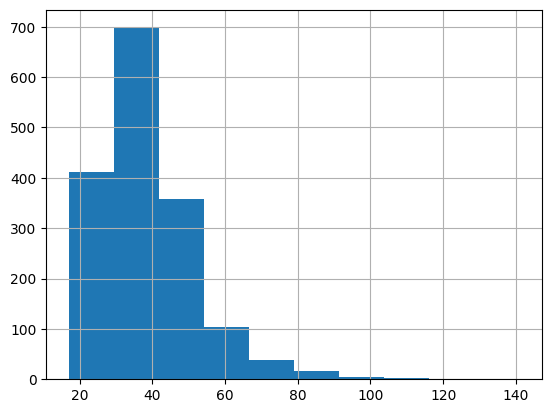

In [19]:
df['tokens_in_ext_desc'].hist()

In [85]:
df['extented_desc_readme_trim'] = df['extented_desc_readme'].apply(lambda x: x[:22000] if pd.notna(x) else x)


In [86]:
df['tokens_in_ext_desc_readme_trim'] = df['extented_desc_readme_trim'].apply(num_tokens_from_string)

<Axes: >

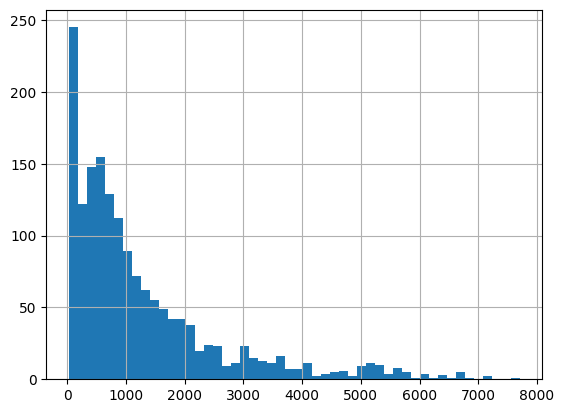

In [87]:
df['tokens_in_ext_desc_readme_trim'].hist(bins = 50)

In [20]:
assert df['tokens_in_ext_desc'].sum() < 100000
# as if Nov 7 2023 allshort  descriptions of tools is jsut 68K tokens, so
# no need for embed db truly speaking, can also just make claude calls every time need to pick a tool

In [21]:
assert df.Name.nunique() == df.shape[0]

In [33]:
df['extented_desc'].isna().sum()

0

In [34]:
df['Code'].isna().sum()

13

In [45]:
df['Readme'].isna().sum()

0

In [47]:
df['Readme'].head(20)

0     # acorde: isoform co-usage networks from singl...
1     # Automated Cell Type Identification using Neu...
2                                                      
3     ## ACTIONet R Package\nSee [ACTIONet-R](https:...
4     # ACTIVA: Realistic scRNAseq Generation with A...
5     # activeSVC\nActiveSVC selects features for la...
6     # **ADC**\r\n\r\nADC is an efficient method to...
7     \n\n A Parameter-free Deep Embedded Clustering...
8     \n<!-- badges: start -->\n[![Build Status](htt...
9     # Description\nadobo is a Python-framework for...
10                                                     
11    # AE-TPGG\n\n\nThis is a autoencoder based on ...
12    \n<!-- README.md is generated from README.Rmd....
13    # airpart\nDifferential allelic imbalance part...
14    # aLDG\n\nWelcome to ``aLDG``!  ``aLDG`` is an...
15    <img alt="logo" src="https://github.com/COMBIN...
16    ## alevinQC\n\n[![Codecov.io coverage status](...
17    # Adaptively-thresholded Low Rank Approxim

In [60]:
df['Readme'] = df['Readme'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' ').replace("'", "\\'") if pd.notna(x) else x)

Embedd Vectors 

In [57]:
# Add the content vectors
scrnatools_description_collection.add(
    documents = list(df['extented_desc']),
    metadatas = df.drop(['extented_desc'], axis = 1).to_dict(orient='records'),
    ids = list(df.Name)
)

In [88]:
scrnatools_description_collection.add(
    documents = list(df['extented_desc_readme_trim']),
    metadatas = df.drop(['extented_desc_readme_trim'], axis = 1).to_dict(orient='records'),
    ids = list(df.Name))

Add of existing embedding ID: acorde
Add of existing embedding ID: ACTINN
Add of existing embedding ID: ACTION
Add of existing embedding ID: ACTIONet
Add of existing embedding ID: ACTIVA
Add of existing embedding ID: activeSVC
Add of existing embedding ID: ADC
Add of existing embedding ID: ADClust
Add of existing embedding ID: ADImpute
Add of existing embedding ID: adobo
Add of existing embedding ID: adverSCarial
Add of existing embedding ID: AE-TPGG
Add of existing embedding ID: aggregateBioVar
Add of existing embedding ID: airpart
Add of existing embedding ID: aLDG
Add of existing embedding ID: alevin-fry
Add of existing embedding ID: alevinQC
Add of existing embedding ID: ALRA
Add of existing embedding ID: AltAnalyze
Add of existing embedding ID: AlzScPred
Add of existing embedding ID: AmbientContaminationMetrics
Add of existing embedding ID: anchor
Add of existing embedding ID: ANS
Add of existing embedding ID: anticor_features
Add of existing embedding ID: APL
Add of existing embe

Query DB

In [29]:
def query_collection(collection, query, max_results, dataframe):
    results = collection.query(query_texts=query, n_results=max_results, include=['distances'])
    df = pd.DataFrame({
                'id':results['ids'][0],
                'score':results['distances'][0],
                'content': dataframe[dataframe.Name.isin(results['ids'][0])]['extented_desc'],
                'platform': dataframe[dataframe.Name.isin(results['ids'][0])]['Platform'],
                })

    return df

In [30]:
query_collection(scrnatools_description_collection, 'quality controll python', 5, df)

,id,score,content,platform
20,AmbientContaminationMetrics,0.365000,Platform: Python\n Description: Quantification...,Python
305,ddqc,0.395694,Platform: Python/R\n Description: Biology-cent...,Python/R
390,SinQC,0.401830,Platform: Python\n Description: Quality contro...,Python
451,fba,0.412007,Platform: Python\n Description: A flexible and...,Python
1427,DrSeq2,0.416470,Platform: R/Python\n Description: A Method and...,R/Python
